# Mask RCNN Inference and Segmentation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings

# Ignore the annoying warnings that come up, there are many of them.
warnings.filterwarnings("ignore")

# Set environment variable CUDA_VISIBLE_DEVICES to "-1" to prevent
# tensorflow from using any GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import io
import os
import sys
import random
import math
import re
import time
import json
from collections import defaultdict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage
from skimage.io import imread, imsave
from skimage.transform import resize

import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Custom logging libaries
from ds_toolbox.ds_logging import add_log_file, set_log_level
from ds_toolbox.ds_logging import info, debug, warn, error
set_log_level("debug")

# Import ade20k_coco library
import ade20k_coco
from ade20k_coco import Ade20kCocoConfig, Ade20kCocoDataset

# Ignore Tensorflow Deprecation Warnings
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Ignore additional warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# Set SEED for numpy
SEED = 10
np.random.seed(SEED)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


# HED Model
Load the model. If `hed_pretrained_bsds.caffemodel` is not found, run the following in the same directory as this notebook:
```
wget http://vcl.ucsd.edu/hed/hed_pretrained_bsds.caffemodel
```

In [3]:
prototxt = "deploy.prototxt"
caffemodel = "hed_pretrained_bsds.caffemodel"
target_w = target_h = 500

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

cv2.dnn_registerLayer('Crop', CropLayer)
# Load the model.
net = cv2.dnn.readNet(prototxt, caffemodel)

In [4]:
# TODO: enter relative path to dataset
DATASET_ROOT = os.path.join(ROOT_DIR, "datasets/ade20k_coco_v4") 

dataset_train = ade20k_coco.Ade20kCocoDataset()
dataset_train.load_coco(DATASET_ROOT, "train")

dataset_val = ade20k_coco.Ade20kCocoDataset()
dataset_val.load_coco(DATASET_ROOT, "val")

# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()

n_classes = dataset_train.num_classes

print(f"Image Count (train/val): {len(dataset_train.image_ids)}/{len(dataset_val.image_ids)}")
print("Class Count: {}".format(n_classes))

labelmap = {i['id']: i['name'] for i in dataset_train.class_info}
print(f"Labelmap: {labelmap}")

# Ensure this is correct.
WALL_ID = 3
WALL_LABEL = labelmap[WALL_ID]
print(f"{WALL_ID} ==> {WALL_LABEL}")
assert "wall" in WALL_LABEL

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Image Count (train/val): 4987/500
Class Count: 5
Labelmap: {0: 'BG', 1: 'ceiling', 2: 'floor, flooring', 3: 'wall', 4: 'windowpane, window'}
3 ==> wall


In [5]:
%%time

class InferenceConfig(Ade20kCocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()
model.load_weights(model_path, by_name=True)

Re-starting from epoch 9
CPU times: user 10.1 s, sys: 649 ms, total: 10.8 s
Wall time: 9.47 s


In [7]:
def use_model(file_id=None):
    if file_id is None:
        file_id = np.random.choice(dataset_val.image_ids)
    
    fname = f"/home/mxs8x15/datasets/coco_ade20k_v4/val2014/{file_id}.jpg"
    debug(f"Using image val2014/{file_id}.jpg")
    
    real_img = imread(fname)
    molded_images, image_metas, windows = model.mold_inputs([real_img])
    km = model.keras_model
    image_shape = (image_metas.astype(int).squeeze())[4:7]
    
    anchors = model.get_anchors(image_shape)
    anchors = np.broadcast_to(anchors, (model.config.BATCH_SIZE,) + anchors.shape)
    
    # Run model through keras model.
    detections, _, _, mrcnn_mask, _, _, _ = km.predict([molded_images,
                                                        image_metas, 
                                                        anchors], verbose=0)
    
    i = 0
    detections = detections[i]
    mrcnn_mask = mrcnn_mask[i]

    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]
    debug(f"There are {N} detections for image {file_id}.jpg")

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores = detections[:N, 5]
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]
    
    image_metas = image_metas.astype(int).squeeze()
    image_shape = image_metas[4:7]
    (start_row, start_col, end_row, end_col) = image_metas[7:11]

    # Convert boxes to pixel coordinates on the original image
    denormed_boxes = utils.denorm_boxes(boxes, image_shape[:2])
    instance_masks = []

    for i in range(N):
        bbox = denormed_boxes[i]
        mask = masks[i]
        y1, x1, y2, x2 = bbox
        detected_mask = utils.resize(mask, (y2 - y1, x2 - x1))
        
        # Put the mask in the right location.
        full_mask = np.zeros(image_shape[:2])
        full_mask[y1:y2, x1:x2] = detected_mask
        instance_masks.append(full_mask)

    stacked_instance_masks = np.array(instance_masks)
    h, w, _ = image_shape
    raw_confidence_masks = np.zeros((n_classes, h, w))

    # Uniform 30% chance of being label 0: BG
    raw_confidence_masks[0] = np.ones((h, w)) * 0.30

    for idx in range(N):
        conf_mask = instance_masks[idx]
        label = class_ids[idx]
        raw_confidence_masks[label] = np.maximum(raw_confidence_masks[label], conf_mask)
        
    # Tranpose the conf mask so it becomes (h, w, n_classes)
    raw_confidence_masks = np.transpose(raw_confidence_masks, axes=[1, 2, 0])

    # Crop down to the dimensions of the molded image pre-padding.
    cropped_masks = raw_confidence_masks[start_row:end_row, start_col:end_col, :]
    
    # Resize the mask to the size of the image
    resized_masks = skimage.transform.resize(cropped_masks, real_img.shape[:2])
    
    pred_mask = np.argmax(resized_masks, axis=-1)
    conf_mask = np.max(resized_masks, axis=-1)
    
    # [instance_id, h, w] ==> [h, w, instance_id]
    debug(stacked_instance_masks.shape)
    stacked_instance_masks = np.transpose(stacked_instance_masks, axes=[1, 2, 0])
    debug(stacked_instance_masks.shape)
    cropped_instance_masks = skimage.transform.resize(stacked_instance_masks,
                                                      real_img.shape[:2])
    
#     scaled_img = skimage.transform.resize(cropped_masks, pred_mask.shape[:2])

    return (real_img, pred_mask, conf_mask, cropped_instance_masks)

In [8]:
%%time 
# (img, pred_mask, conf_mask, instance_masks) = use_model(117)
(img, raw_seg, conf_mask, instance_masks) = use_model(301)

04/27/2020 07:18:05 PM [DEBUG] Using image val2014/301.jpg
04/27/2020 07:18:11 PM [DEBUG] There are 4 detections for image 301.jpg
04/27/2020 07:18:11 PM [DEBUG] (4, 1024, 1024)
04/27/2020 07:18:11 PM [DEBUG] (1024, 1024, 4)


CPU times: user 28.4 s, sys: 1.12 s, total: 29.6 s
Wall time: 5.68 s


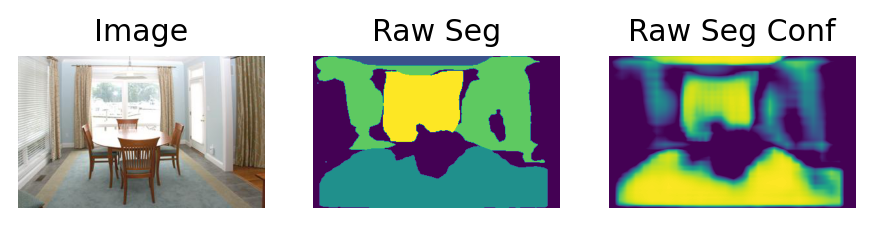

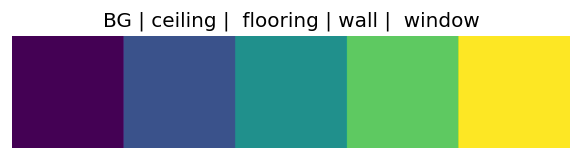

In [9]:
plt.figure(dpi=180)
plt.axis("off")
ax = plt.subplot(1, 3, 1); ax.axis("off"); ax.set_title("Image"); ax.imshow(img)
ax = plt.subplot(1, 3, 2); ax.axis("off"); ax.set_title("Raw Seg"); ax.imshow(raw_seg)
ax = plt.subplot(1, 3, 3); ax.axis("off"); ax.set_title("Raw Seg Conf"); ax.imshow(conf_mask)

plt.figure(dpi=120)
present_classes = np.unique(raw_seg)
n_present_classes = len(present_classes)
h = 400
w = h * n_present_classes
legend = np.zeros((h, w), np.uint8)
words = []
title = ""
for idx, val in enumerate(present_classes):
    legend[:, h*idx: h*(idx+1)] = val
    label = labelmap[val]
    # Keep final word in multi-word label
    last_word = label.split(",")[-1]
    words.append(last_word)

plt.axis("off")
plt.title(' | '.join(words))
plt.imshow(legend)

In [10]:
rgb_colors = {
    idx: np.random.choice(np.arange(255), 3) for idx in labelmap.keys()
}

def seg_to_rgb(raw_seg):
    h, w = raw_seg.shape[:2]
    rgb_seg = np.zeros((h, w, 3), np.uint8)
    for idx in labelmap:
        seg_mask = raw_seg == idx
        color = rgb_colors[idx]
        rgb_seg[seg_mask, :] = color
        
    return rgb_seg

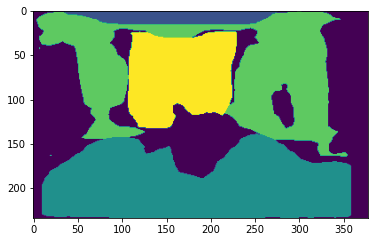

In [11]:
plt.imshow(raw_seg)

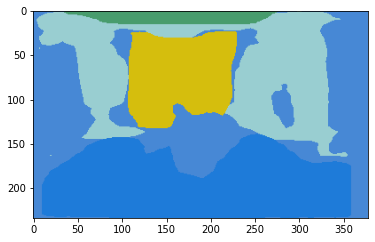

In [12]:
rgb_seg = seg_to_rgb(raw_seg)
plt.imshow(rgb_seg)

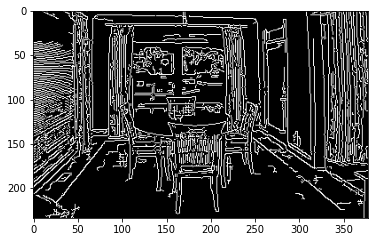

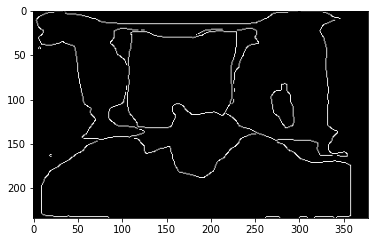

In [14]:
# canny_edges = cv2.Canny(img, 50, 150, apertureSize=3, L2gradient=True)
canny_img = cv2.Canny(img, 50, 120, apertureSize=3)
canny_seg = cv2.Canny(rgb_seg, 50, 120, apertureSize=3)
plt.imshow(canny_img, cmap="gray")
plt.figure(); plt.imshow(canny_seg, cmap="gray")

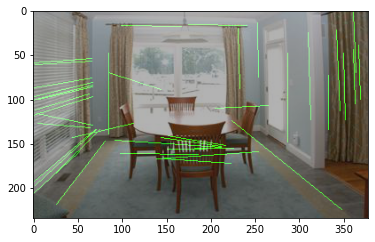

In [21]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 35  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

line_lengths = []
for line in lines:
    line = line.flatten()
    x1,y1,x2,y2 = line
    line_vector = np.array([y2-y1, x2-x1])
    vec_norm = np.linalg.norm(line_vector)

    line_lengths.append((vec_norm, line))
        
# Sort by length
line_lengths = sorted(line_lengths, key=lambda x: x[0], reverse=True)
_, lines = list(zip(*line_lengths[:40]))


for x1,y1,x2,y2 in lines:
    line_vector = np.array([y2-y1, x2-x1])
    vec_norm = np.linalg.norm(line_vector)

#         if vec_norm > 90:
#             print(vec_norm)
    cv2.line(line_image,(x1,y1),(x2,y2),(0, 255, 0), 1)
        
lines_edges = cv2.addWeighted(img, 0.7, line_image, 1, 0)
plt.imshow(lines_edges)

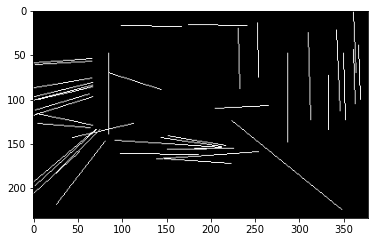

In [22]:
new_edges = line_image[:, :, 1].copy()
new_edges[new_edges != 0] = 1
plt.imshow(new_edges, cmap="gray")

# Use Line Segment Intersections

In [23]:
def get_line(x1, y1, x2, y2):
    pt1 = np.array([x1, y1, 1])
    pt2 = np.array([x2, y2, 1])
    line = np.cross(pt1, pt2)
    return line

def distance(xs, ys, xe, ye):
    """Distance between a starting and ending point"""
    return np.sqrt((ye - ys) ** 2 + (xe - xs) ** 2)

def point_on_line(line, x, y):
    """Return whether or not the point (x1, y1) is on the line.
    
    This is true if the dot produce of line and [x1 y1 1] is 0.
    Alternatively, if (ax + by + c = 0) holds true.
    """
    point = np.array([x, y, 1])
    return (0 == np.dot(line, point))


def point_already_drawn(x1, y1, x2, y2):
#     TODO: Implement this
    return False

def solve_for_x(line, y, approx=True):
    a, b, c = line
    if a == 0:
        return np.inf

    x = -((b*y + c) / a)
    if approx:
        x = np.round(x).astype(int)
    return x


def solve_for_y(line, x, approx=True):
    a, b, c = line
    if b == 0:
        return np.inf
    
    y = -((a*x + c) / b)
    if approx:
        y = np.round(y).astype(int)
    
    return y

In [24]:
def get_intersect(a1, a2, b1, b2):
    """
    Intersection point of two vectors, A and B: https://stackoverflow.com/a/42727584
    
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

## Test Intersection Code

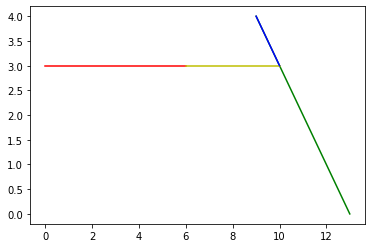

In [25]:
x1, y1, x2, y2 = 0, 3, 6, 3
x3, y3, x4, y4 = 13, 0, 9, 4
real_answer = (10, 3)
pred_answer = get_intersect((x1, y1), (x2, y2), (x3, y3), (x4, y4))
assert real_answer == pred_answer
(px, py) = pred_answer

xs = np.array([x1, x2])
ys = np.array([y1, y2])
plt.plot(xs, ys, 'r')  # Red

xs = np.array([x3, x4])
ys = np.array([y3, y4])
plt.plot(xs, ys, 'g')  # Green

xs = np.array([x2, px])
ys = np.array([y2, py])
plt.plot(xs, ys, 'y')  # Yellow

xs = np.array([x4, px])
ys = np.array([y4, py])
plt.plot(xs, ys, 'b')  # Blue

## Trial 1

04/27/2020 07:31:25 PM [DEBUG] (20.615528128088304, (271, 161), (255, 148))
04/27/2020 07:31:25 PM [DEBUG] (21.02379604162864, (46, 143), (67, 144))
04/27/2020 07:31:25 PM [DEBUG] (31.064449134018133, (255, 159), (224, 161))
04/27/2020 07:31:25 PM [DEBUG] (22.0, (287, 174), (287, 152))
04/27/2020 07:31:25 PM [DEBUG] (23.021728866442675, (315, 167), (314, 144))
04/27/2020 07:31:25 PM [DEBUG] (23.345235059857504, (75, 131), (92, 115))
04/27/2020 07:31:25 PM [DEBUG] (22.02271554554524, (21, 175), (38, 161))
04/27/2020 07:31:25 PM [DEBUG] (20.024984394500787, (349, 172), (348, 152))
04/27/2020 07:31:25 PM [DEBUG] (20.0, (85, 141), (85, 121))
04/27/2020 07:31:25 PM [DEBUG] (20.615528128088304, (106, 115), (93, 131))
04/27/2020 07:31:25 PM [DEBUG] (21.0, (276, 162), (255, 162))
04/27/2020 07:31:25 PM [DEBUG] (28.071337695236398, (315, 178), (287, 176))
04/27/2020 07:31:25 PM [DEBUG] (21.02379604162864, (348, 20), (349, 41))
04/27/2020 07:31:25 PM [DEBUG] (22.627416997969522, (78, 131), (94, 

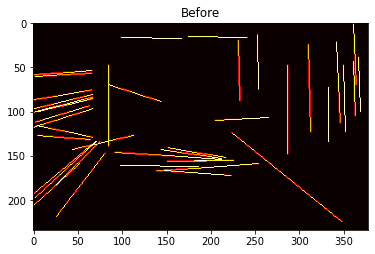

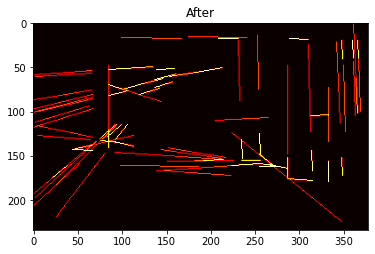

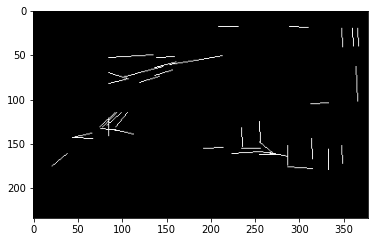

In [34]:
lines = list(lines)

orig_lines = line_image[:, :, 1].copy()
orig_lines[orig_lines == 255] = 1
long_lines = orig_lines.copy()

height, width = long_lines.shape
DIST_THRESH = 20

IDX_END = len(lines)
# OUTER LOOP BEGIN
i = 0
while i < IDX_END:  # Use while since we will modify lines in-place
    (x3, y3, x4, y4) = lines[i]
    
    # Tuples of the form (point, dist)
    points_and_dists = []
    
    # INNER LOOP BEGIN
    for j, (x1, y1, x2, y2) in enumerate(lines):
        if j == i:
            continue

        px, py = get_intersect((x1, y1), (x2, y2), (x3, y3), (x4, y4))

        # Check if this point is already on either line
#         line1 = get_line(x1, y1, x2, y2)
#         line2 = get_line(x3, y3, x4, y4)
#         on_line1 = point_on_line(line1, px, py)
#         on_line2 = point_on_line(line2, px, py)

#         on_current_line = on_line1
#         if on_current_line:  # Don't draw if it's on the line already
#             continue
        
#         if not on_line1 and not on_line2:
#             # Ignore this point, nothing to draw
#             continue  

        point = np.round(np.array([px, py])).astype(int)
        point = tuple(point.tolist())
        px, py = point

        if 0 <= px < width and 0 <= py < height:
            dist_start = distance(px, py, x3, y3)
            dist_end = distance(px, py, x4, y4)
            
            dists = [(dist_start, (x3, y3)), (dist_end, (x4, y4))]
            dist, anchor = min(dists, key=lambda x: x[0])
            
            if dist >= DIST_THRESH:
                # Add to list to consider.
                points_and_dists.append((dist, point, anchor))
            
#             if dist < DIST_THRESH:
#                 # Draw now. Fill value is 2.
#                 cv2.line(long_lines, (px, py), anchor, (2), 1)
#             else:
#                 # Add to list to consider.
#                 points_and_dists.append((dist, point, anchor))

    
    # Find min dist to an intersection.
    points_and_dists = sorted(points_and_dists, key=lambda x: x[0])
    if points_and_dists:
        debug(points_and_dists[0])
        _, point, anchor = points_and_dists[0]

        # Draw a line from (xs, ys) to (px, py) with color "2"
        cv2.line(long_lines, anchor, point, (2,), 1)
        
        # Update coordinates of line i.
        px, py = point
        dist_a = distance(x3, y3, px, py)
        dist_b = distance(x4, y4, px, py)
        # Update the coordinates for this line
        if dist_a >= dist_b:
            lines[i] = (x3, y3, px, py)
        else:
            lines[i] = (x4, y4, px, py)
    
    i += 1

plt.figure(); plt.title("Before"); plt.imshow(orig_lines, cmap="hot")
plt.figure(); plt.title("After"); plt.imshow(long_lines, cmap="hot")
plt.figure(); plt.imshow(long_lines == 2, cmap="gray")

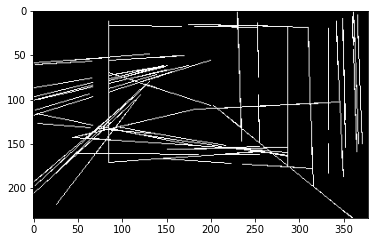

In [186]:
edges = long_lines.copy()
edges[edges != 0] = 1
plt.imshow(edges, cmap="gray")

# Trial 2: Extend All Lines until Image Boundary

In [36]:
solve_for_x??

In [37]:
distance??

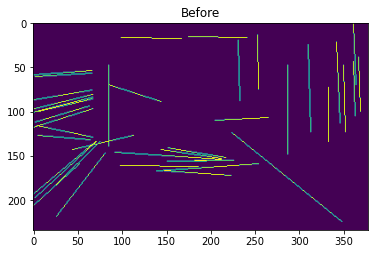

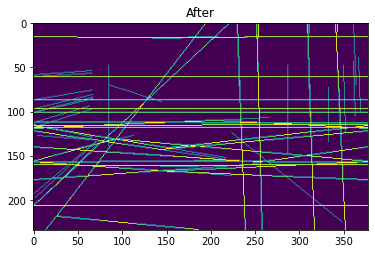

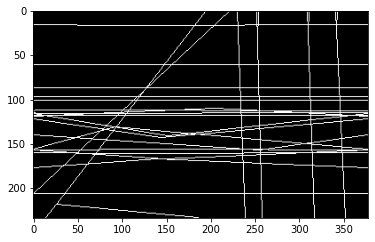

In [47]:
lines = list(lines)

orig_lines = line_image[:, :, 1].copy()
orig_lines[orig_lines == 255] = 1
edges = orig_lines.copy()

height, width = edges.shape
THRESH = 50 

for (x1, y1, x2, y2) in lines:    
    line_eq = get_line(x1, y1, x2, y2)
    a, b, c = line_eq
    
    ray_len = distance(x1, y1, x2, y2)

    if THRESH < ray_len < 2 * THRESH:
        continue
    
    if a == 0:
        # Vertical line
        # TODO: Connect line top-to-bottom
        pass

    elif b == 0:
        # Horizontal line.
        # TODO: Connect line left-to-right
        pass
    
    else:
        # Solve for (x, y) with x=0, y=0
        # Case 1: x = 0
        x = 0
        y = solve_for_y(line_eq, x)
        if 0 <= y <= height:
            # Draw a line from (x1, y1) to (x, y) with color "2"
            y = min(int(round(y)), height - 1)
            cv2.line(edges, (x1, y1), (x, y), (2,), 1)
            
        # Case 2: y = 0
        y = 0
        x = solve_for_x(line_eq, y)
        if 0 <= x <= width:
            # Draw a line from (x1, y1) to (x, y) with color "2"
            x = min(int(round(x)), width - 1)
            cv2.line(edges, (x1, y1), (x, y), (2,), 1)
            

        # Case 3: x = width
        x = width - 1
        y = solve_for_y(line_eq, y)
        if 0 <= x <= width:
            # Draw a line from (x1, y1) to (x, y) with color "2"
            x = min(int(round(x)), width - 1)
            cv2.line(edges, (x1, y1), (x, y), (2,), 1)
            
        
        # Case 4: y = height
        y = height - 1
        x = solve_for_x(line_eq, y)
        if 0 <= x <= width:
            # Draw a line from (x1, y1) to (x, y) with color "2"
            x = min(int(round(x)), width - 1)
            cv2.line(edges, (x1, y1), (x, y), (2,), 1)

plt.figure(); plt.title("Before"); plt.imshow(orig_lines)
plt.figure(); plt.title("After"); plt.imshow(edges)
plt.figure(); plt.imshow(edges == 2, cmap="gray")

04/27/2020 06:47:30 PM [DEBUG] (61.84658438426491, array([255, 149]), (207, 110))
04/27/2020 06:47:30 PM [DEBUG] (52.15361924162119, array([287, 160]), (235, 156))
04/27/2020 06:47:30 PM [DEBUG] (54.147945482723536, array([ 85, 171]), (139, 167))
04/27/2020 06:47:30 PM [DEBUG] (59.0, array([287,  87]), (287, 28))
04/27/2020 06:47:30 PM [DEBUG] (54.037024344425184, array([316, 198]), (314, 144))
04/27/2020 06:47:30 PM [DEBUG] (54.48853090330111, array([ 42, 160]), (2, 197))
04/27/2020 06:47:30 PM [DEBUG] (51.088159097779204, array([ 39, 160]), (0, 193))
04/27/2020 06:47:30 PM [DEBUG] (52.03844732503075, array([344,  74]), (342, 22))
04/27/2020 06:47:30 PM [DEBUG] (52.80151512977634, array([ 61, 173]), (93, 131))
04/27/2020 06:47:30 PM [DEBUG] (50.0, array([ 48, 161]), (98, 161))
04/27/2020 06:47:30 PM [DEBUG] (59.135437767890075, array([315, 178]), (256, 174))
04/27/2020 06:47:30 PM [DEBUG] (51.0098029794274, array([352, 154]), (351, 103))
04/27/2020 06:47:30 PM [DEBUG] (51.623637996561

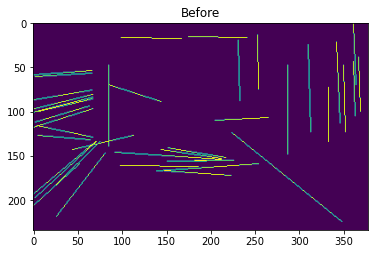

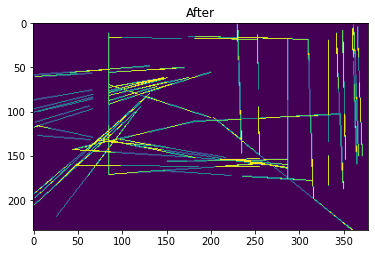

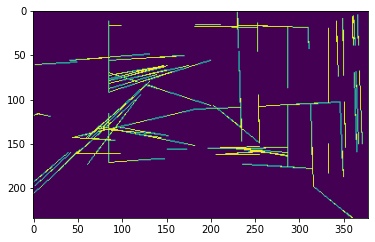

In [185]:
# lines = list(lines)
# orig_lines = line_image[:, :, 0].copy()
# orig_lines[orig_lines == 255] = 1
# long_lines = orig_lines.copy()

# h, w = long_lines.shape

# DIST_THRESH = 50

# END = len(lines)
# # END = 15

# # OUTER LOOP BEGIN
# i = 0
# while i < END:  # Use while since we will modify lines in-place
#     (x3, y3, x4, y4) = lines[i]
    
#     # Tuples of the form (point, dist)
#     points_and_dists = []
    
#     # INNER LOOP BEGIN
#     for j, (x1, y1, x2, y2) in enumerate(lines):
#         if j == i:
#             continue

#         px, py = get_intersect((x1, y1), (x2, y2), (x3, y3), (x4, y4))

#         # Check if this point is already on either line
#         line1 = get_line(x1, y1, x2, y2)
#         line2 = get_line(x3, y3, x4, y4)
#         on_line1 = point_on_line(line1, px, py)
#         on_line2 = point_on_line(line2, px, py)

# #         on_current_line = on_line1
# #         if on_current_line:  # Don't draw if it's on the line already
# #             continue
        
# #         if not on_line1 and not on_line2:
# #             # Ignore this point, nothing to draw
# #             continue  

#         point = np.round(np.array([px, py])).astype(int)
#         px, py = point

#         if 0 <= px < np.inf and 0 <= py < np.inf:
#             dist_start = distance(px, py, x3, y3)
#             dist_end = distance(px, py, x4, y4)
            
#             dists = [(dist_start, (x3, y3)), (dist_end, (x4, y4))]
#             dist, anchor = min(dists, key=lambda x: x[0])
            
#             if dist < DIST_THRESH:
#                 # Draw now.
#                 cv2.line(long_lines, (px, py), anchor, (2), 1)
#             else:
#                 # Add to list to consider.
#                 points_and_dists.append((dist, point, anchor))

    
#     # Find min dist to an intersection.
#     points_and_dists = sorted(points_and_dists, key=lambda x: x[0])
#     if points_and_dists:
#         debug(points_and_dists[0])
#         _, (px, py), (xs, ys) = points_and_dists[0]

#         # Draw a line from (xs, ys) to (px, py) with color "2"
#         cv2.line(long_lines, (px, py), (xs, ys), (2), 1)
        
#         # Update coordinates of line i.
#         dist_a = distance(x3, y3, px, py)
#         dist_b = distance(x4, y4, px, py)
        
#         if dist_a >= dist_b:
#             lines[i] = (x3, y3, px, py)
#         else:
#             lines[i] = (x4, y4, px, py)

#     i += 1

# plt.figure(); plt.title("Before"); plt.imshow(orig_lines)
# plt.figure(); plt.title("After"); plt.imshow(long_lines)
# plt.figure(); plt.imshow(long_lines == 2)

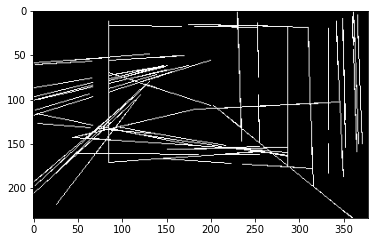

In [188]:
edges = long_lines.copy()
edges[edges != 0] = 1
plt.imshow(edges, cmap="gray")

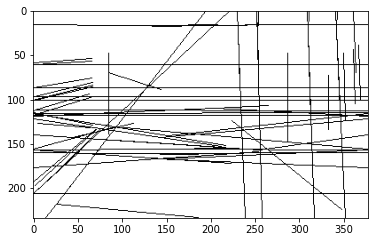

In [48]:
import pickle

edges_inv = edges.copy()
mask0 = edges_inv==0
mask1 = edges_inv != 0
edges_inv[mask0] = 1
edges_inv[mask1] = 0
plt.imshow(edges_inv, cmap="gray")


data = {
    "img": img,
    "edges": edges_inv,
    "raw_seg": raw_seg,
    "conf_mask": conf_mask
}

with open("tmp/data_301.pkl", "wb") as wf:
    pickle.dump(data, wf)

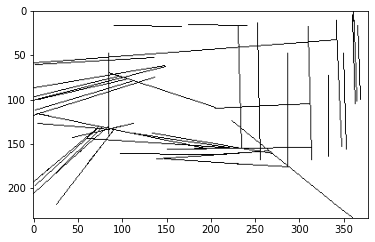

In [178]:
edges_inv = edges.copy()
mask0 = edges_inv==0
mask1 = edges_inv != 0
edges_inv[mask0] = 1
edges_inv[mask1] = 0
plt.imshow(edges_inv, cmap="gray")

In [179]:
import pickle

edges_inv = edges.copy()
mask0 = edges_inv==0
mask1 = edges_inv != 0
edges_inv[mask0] = 1
edges_inv[mask1] = 0
plt.imshow(edges_inv, cmap="gray")


data = {
    "img": img,
    "edges": edges_inv,
    "raw_seg": raw_seg,
    "conf_mask": conf_mask
}

with open("tmp/data_301.pkl", "wb") as wf:
    pickle.dump(data, wf)

152 141 217 152
Rise: 11  Run: 65, Norm: 65 N: 60
xmin, xmax, ymin, ymax: (122.75, 181.25, 136.05, 156.95)
[217 216 216 215 215 214 213 213 212 212 211 210 210 209 209 208 207 207
 206 205 205 204 204 203 202 202 201 201 200 199 199 198 198 197 196 196
 195 195 194 193 193 192 192 191 190 190 189 189 188 187 187 186 185 185
 184 184 183 182 182 181] [152 152 152 152 152 152 153 153 153 153 153 153 153 153 153 153 153 153
 154 154 154 154 154 154 154 154 154 154 154 154 155 155 155 155 155 155
 155 155 155 155 155 155 156 156 156 156 156 156 156 156 156 156 156 156
 157 157 157 157 157 157]
Stop forward at (216, 152)
[152 152 151 151 150 150 149 149 148 148 147 147 146 146 145 145 144 144
 143 143 142 142 141 141 140 140 139 139 138 138 137 137 136 136 135 135
 134 134 133 133 132 132 131 131 130 130 129 129 128 128 127 127 126 126
 125 125 124 124 123 123] [141 141 141 141 141 141 140 140 140 140 140 140 140 140 140 140 140 140
 139 139 139 139 139 139 139 139 139 139 139 139 138 138 1

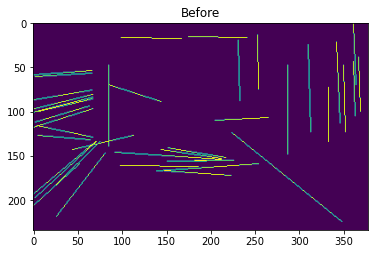

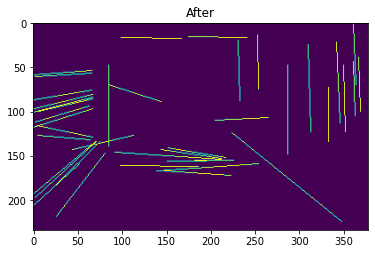

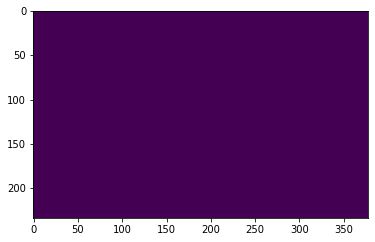

In [21]:
long_lines = new_edges.copy()
h, w = new_edges.shape
R = 0.45
# TODO: Handle case where one coordinate increases while other decreases.
# TODO: Find neighbors in neighborhood, if too many already colored in, deleted this
# line.

for (x1, y1, x2, y2) in lines[28:]:
    run = abs(x2 - x1)
    rise = abs(y2 - y1)
    vec = np.array([rise, run])
    norm = np.linalg.norm(vec).astype(int)
    N = np.median([30, norm, 60]).astype(int)
    
    print(x1, y1, x2, y2)
    print(f"Rise: {rise}  Run: {run}, Norm: {norm} N: {N}")

    xmin = max(x1 - (R * run), 0)
    xmax = min(x1 + (R * run), w)
    
    ymin = max(y1 - (R * rise), 0)
    ymax = min(y2 + (R * rise), h)
    
    print(f"xmin, xmax, ymin, ymax: {xmin, xmax, ymin, ymax}")
    
    # Go from x2,y2 to xmax, ymax
    xrange = np.round(np.linspace(x2, xmax, N)).astype(int)
    yrange = np.round(np.linspace(y2, ymax, N)).astype(int)
    print(xrange, yrange)

    fin_x, fin_y = None, None
    prev_x, prev_y = None, None
    for i in range(1, N):
        x = xrange[i]
        y = yrange[i]
        
        if (x == prev_x) and (y == prev_y):
            continue
        prev_x, prev_y = x, y
        
        if not (0 <= x < w and 0 <= y < h):
            continue
            
        if long_lines[y, x] == 0:
            long_lines[y, x] = 2
        
        else:
            # We found an intersection, stop here.
            print(f"Stop forward at {x, y}")
            fin_x, fin_y = x, y
            break
            
    
    # Go from x1,y1 downto xmin, ymin
    xrange = np.round(np.linspace(xmin, x1, N)).astype(int)[::-1]
    yrange = np.round(np.linspace(ymin, y1, N)).astype(int)[::-1]
    print(xrange, yrange)
    
    start_x, start_y = None, None
    
    prev_x, prev_y = None, None
    for i in np.arange(1, N):
        x = xrange[i]
        y = yrange[i]
        
        if (x == prev_x) and (y == prev_y):
            continue
        prev_x, prev_y = x, y
        
        if not (0 <= x < w and 0 <= y < h):
            continue
            
        if long_lines[y, x] == 0:
            long_lines[y, x] = 2
        
        else:
            # We found an intersection, stop here.
            print(f"Stop back at {x, y}")
            start_x, start_y = x, y
            break
            
    break

plt.figure(); plt.title("Before"); plt.imshow(new_edges)
plt.figure(); plt.title("After"); plt.imshow(long_lines)
plt.figure(); plt.imshow(long_lines == 2)